# **Big Data Final Project - Protein Atlas**
Windy Aldeborgh, Fiona Erickson, Louis Haskins, Kirby Hood

Presentation deck: https://docs.google.com/presentation/d/19MTT2DkSH4YAEn8N9PxTUNSU6k4G1AsA-EBT0W0luTo/edit?usp=sharing

Data Source: https://www.kaggle.com/c/human-protein-atlas-image-classification/data

In [0]:
# Data is read in via Kaggle API
!pip install kaggle

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.12.0


## Getting the Data

In [0]:
# Connecting to Kaggle API - must create google key to get access
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions download -c human-protein-atlas-image-classification

  0% 0.00/446k [00:00<?, ?B/s]
100% 446k/446k [00:00<00:00, 29.3MB/s]
  0% 0.00/1.22M [00:00<?, ?B/s]
100% 1.22M/1.22M [00:00<00:00, 39.8MB/s]
100% 4.36G/4.37G [00:36<00:00, 136MB/s]
100% 4.37G/4.37G [00:36<00:00, 128MB/s]
100% 13.1G/13.1G [01:52<00:00, 127MB/s]
100% 13.1G/13.1G [01:52<00:00, 125MB/s]


In [0]:
from zipfile import ZipFile
import re

In [0]:
#Extract all Green Filter Test Images

path = 'test/'

Zip = ZipFile('test.zip')
for info in Zip.infolist():
 if re.match(r'.*_green.*\.png$', info.filename):
   #print (info.filename)
   Zip.extract(info,path )

In [0]:
#Extract all Green Filter Train Images

path = 'train/'

Zip = ZipFile('train.zip')
for info in Zip.infolist():
  if re.match(r'.*_green.*\.png$', info.filename):
   #print (info.filename)
    Zip.extract(info,path )

In [0]:
import pandas as pd
train_labels = pd.read_csv('train.csv', sep=',')

In [0]:
train_labels.Id.head()

0    00070df0-bbc3-11e8-b2bc-ac1f6b6435d0
1    000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
2    000a9596-bbc4-11e8-b2bc-ac1f6b6435d0
3    000c99ba-bba4-11e8-b2b9-ac1f6b6435d0
4    001838f8-bbca-11e8-b2bc-ac1f6b6435d0
Name: Id, dtype: object

## Preprocessing and Exploration

In [0]:
# Labels are read in as 0-27, provide names for each class   
  label_names = {
        0:  "Nucleoplasm",  
        1:  "Nuclear membrane",   
        2:  "Nucleoli",   
        3:  "Nucleoli fibrillar center",   
        4:  "Nuclear speckles",
        5:  "Nuclear bodies",   
        6:  "Endoplasmic reticulum",   
        7:  "Golgi apparatus",   
        8:  "Peroxisomes",   
        9:  "Endosomes",   
        10:  "Lysosomes",   
        11:  "Intermediate filaments",   
        12:  "Actin filaments",   
        13:  "Focal adhesion sites",   
        14:  "Microtubules",   
        15:  "Microtubule ends",   
        16:  "Cytokinetic bridge",   
        17:  "Mitotic spindle",   
        18:  "Microtubule organizing center",   
        19:  "Centrosome",   
        20:  "Lipid droplets",   
        21:  "Plasma membrane",   
        22:  "Cell junctions",   
        23:  "Mitochondria",   
        24:  "Aggresome",   
        25:  "Cytosol",   
        26:  "Cytoplasmic bodies",   
        27:  "Rods & rings"
    }
  


In [0]:
reverse_train_labels = dict((v,k) for k,v in label_names.items())

In [0]:
# Create a data set with an array column containing the list of proteins in each image

train_labels[f'target_vec'] = train_labels['Target'].map(lambda x: list(map(int, x.strip().split())))
for i in range(28):
    train_labels[f'{label_names[i]}'] = train_labels['Target'].map(
             lambda x: 1 if str(i) in x.strip().split() else 0)
train_labels.head()

,Id,Target,target_vec,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,"[16, 0]",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,[5],0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,[1],0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,[18],0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [0]:
#flatui = ["#0bdebf", "#058687", "#112e40ff", "#ed553b", “#ffffff"]
#sns.palplot(sns.
colors = ["aqua", "turquoise", "bluegreen", "very dark blue", "orangey red"]
sns.palplot(sns.xkcd_palette(colors))
sns.set_palette(sns.xkcd_palette(colors))
sns.set_style("whitegrid")

In [0]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * train_labels["number_of_targets"].value_counts() / train_labels.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values)
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")

In [0]:
# Correlation between proteins
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(train_labels[train_labels.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="GnBu", vmin=-1, vmax=1)

In [0]:
# Agreesomes
def find_counts(special_target, labels):
    counts = labels[labels[special_target] == 1].drop(
        ["Id", "Target", "number_of_targets"],axis=1
    ).sum(axis=0)
    counts = counts[counts > 0]
    counts = counts.sort_values()
    return counts

In [0]:
aggresomeCount = find_counts("Aggresome", train_labels)

plt.figure(figsize=(10,3))
sns.barplot(x=aggresomeCount.values,y=aggresomeCount.index.values, palette="Spectral")

In [0]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


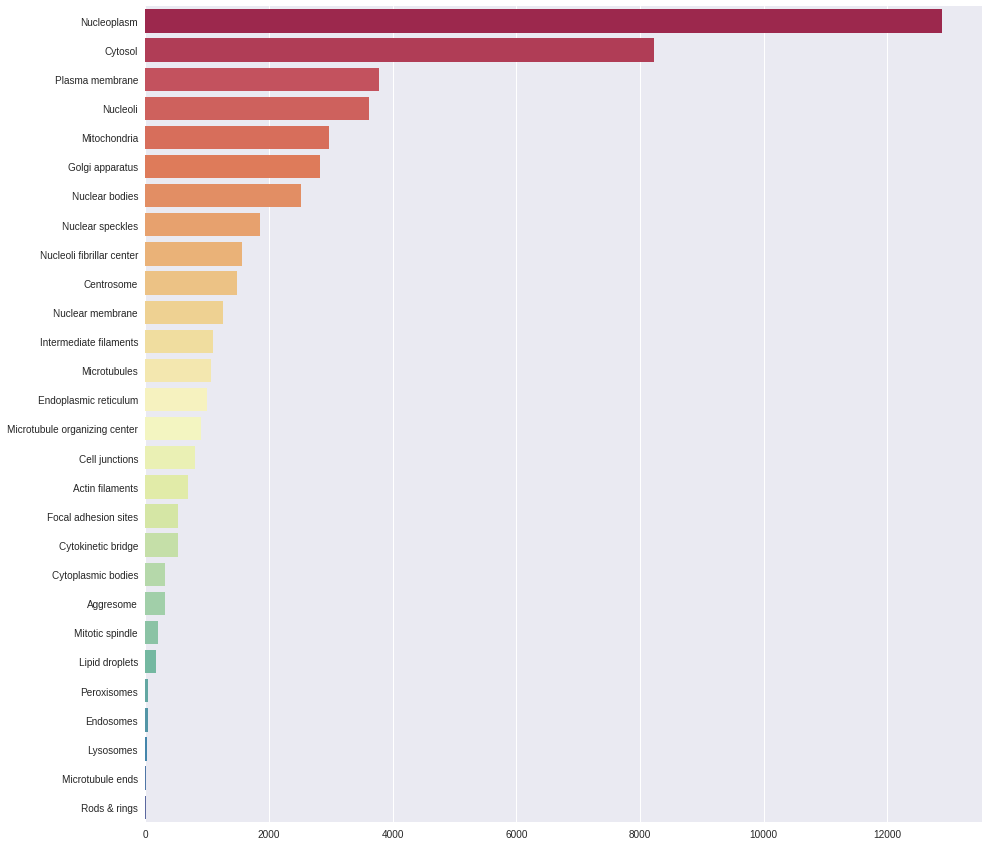

In [0]:
# Plot overall dataset class distribution

import seaborn as sns

target_counts = train_labels.drop(["Id", "Target", "target_vec"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index, palette="Spectral")

### Aggresome dataset

In [0]:

class_index = 24  # Aggresomes
aggresome_labels = train_labels.loc[(train_labels[label_names[class_index]] == 1)]
print(f'shape before {train_labels.shape}, shape after {aggresome_labels.shape}')
aggresome_labels.head()

shape before (31072, 31), shape after (322, 31)


,Id,Target,target_vec,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
12,0032a07e-bba9-11e8-b2ba-ac1f6b6435d0,24 0,"[24, 0]",1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
264,024f5654-bbae-11e8-b2ba-ac1f6b6435d0,24 22,"[24, 22]",0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
334,02f839b2-bba5-11e8-b2ba-ac1f6b6435d0,24 18,"[24, 18]",0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
344,03181d4e-bbb0-11e8-b2ba-ac1f6b6435d0,24 21,"[24, 21]",0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
358,033f4c8a-bb9b-11e8-b2b9-ac1f6b6435d0,24 11,"[24, 11]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


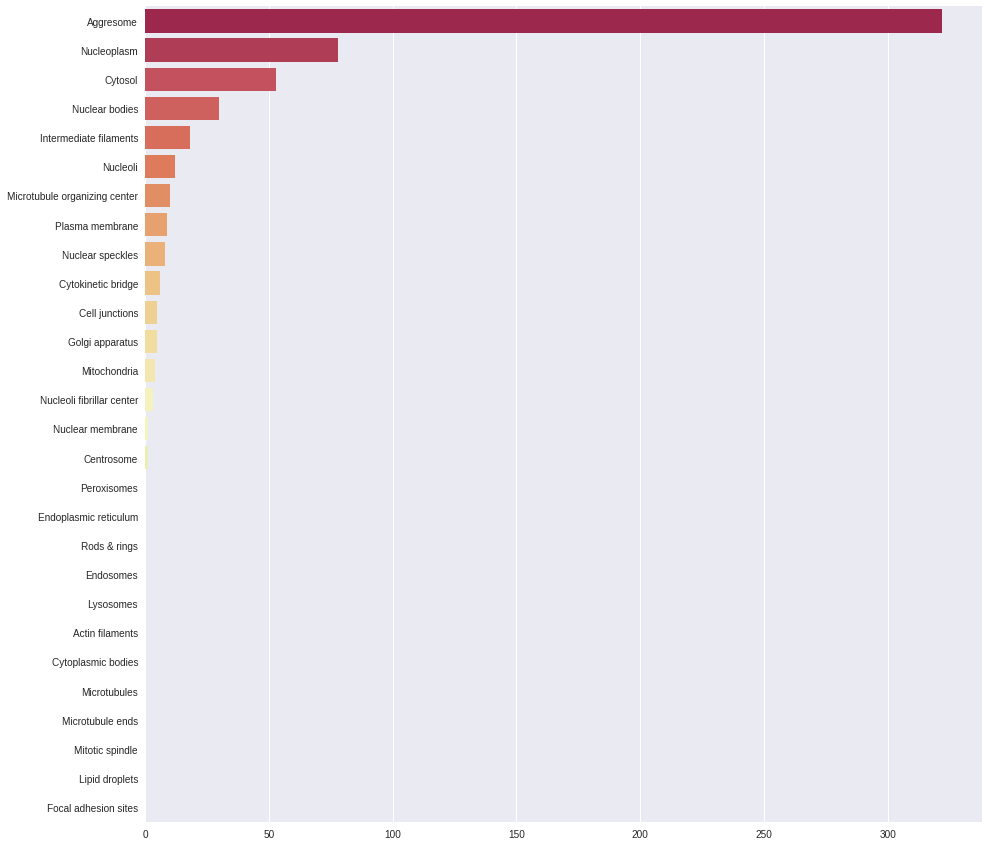

In [0]:
# Plot Aggresome dataset distribution

target_counts = aggresome_labels.drop(["Id", "Target", "target_vec"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index, palette="Spectral")

### Downsampled dataset with all classes

In [0]:
# Downsample the dataset to try and reduce the skew and the number of overall images
samples = [6,8,9,10,12,13,14,15,16,17,18,20,22,24,26,27]
  
train_samples = train_labels
  
for row, index in train_samples.iterrows():
    if any([i in train_samples.target_vec[row] for i in samples]):
      continue
    else:
      train_samples = train_samples.drop([row])
      

In [0]:
train_samples.head()
train_samples.shape

(6255, 31)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


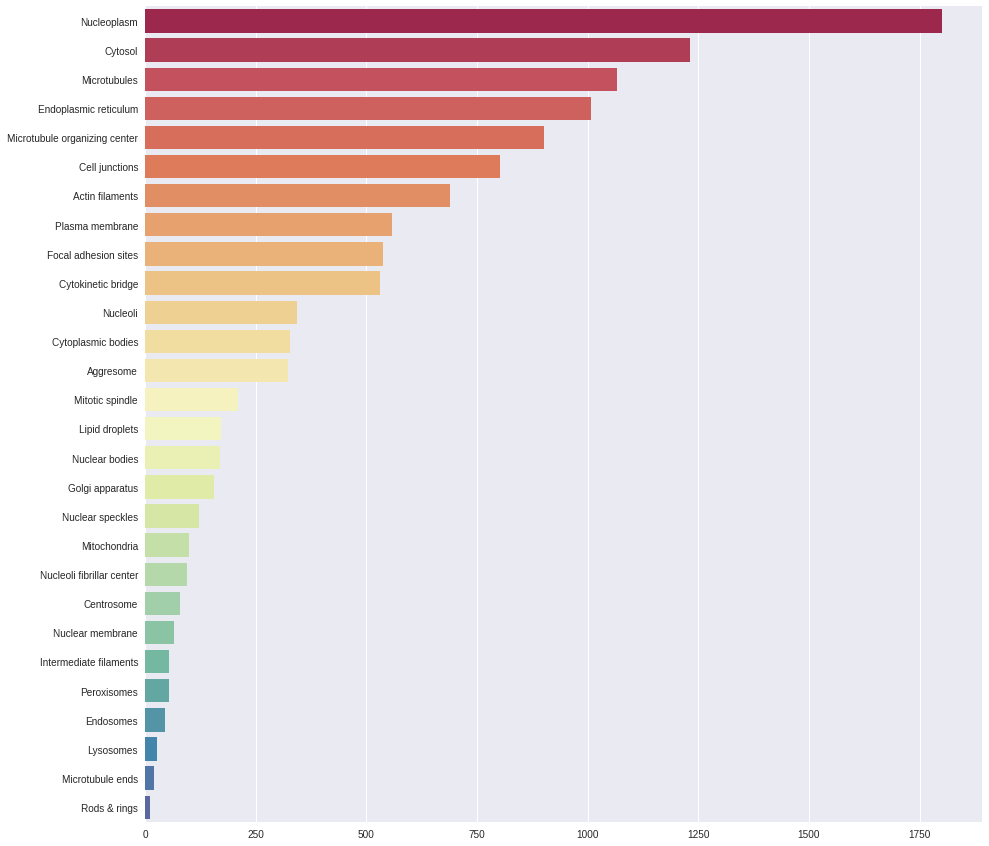

In [0]:
#Plot down-sampled dataset distribution
target_counts = train_samples.drop(["Id", "Target", "target_vec"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index, palette="Spectral")

## Model Building

In [0]:
!pip install imgaug

In [0]:
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

# ** Aggresome Only Model**

In [0]:
# First Model build using only aggresome data with 4 Activation Functions including Relu and Softmax and a droprate of 0.25
BATCH_SIZE = 128
SEED = 777
SHAPE = (512, 512,1)
DIR = './'
VAL_RATIO = 0.1 # 10 % as validation
THRESHOLD = 0.05 # due to different cost of True Positive vs False Positive, this is the probability threshold to predict the class as 'yes'

ia.seed(SEED)


In [0]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = aggresome_labels

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

In [0]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        G = Image.open(path + '_green.png')

        im = np.array(G)
        
        im = im.reshape([512, 512,1])
        im = np.divide(im, 255)
        return im

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf

from tensorflow import set_random_seed
set_random_seed(SEED)

In [0]:
# credits: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [0]:
def create_model(input_shape):
    
    dropRate = 0.25
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(8, (3, 3), padding="same", input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(16, (3, 3), padding="same")(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(28, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(28, activation='softmax')(x)
    
    model = Model(init, x)
    
    return model

In [0]:
model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 512, 1)       4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 8)       80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 16)      1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
__________

In [0]:
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=True, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=True, shuffle = False)

# https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

(6255,) (6255, 28)
(5629,) (5629, 28) (626,) (626, 28)


In [0]:
epochs = 30

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

Epoch 1/30
44/44 [==============================] - 79s 2s/step - loss: 0.2653 - acc: 0.9338 - f1: 0.0065 - val_loss: 0.2534 - val_acc: 0.9334 - val_f1: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.25339, saving model to ./base.model
Epoch 2/30
44/44 [==============================] - 39s 892ms/step - loss: 0.2493 - acc: 0.9344 - f1: 1.2790e-04 - val_loss: 0.2505 - val_acc: 0.9336 - val_f1: 0.0000e+00

Epoch 00002: val_loss improved from 0.25339 to 0.25046, saving model to ./base.model
Epoch 3/30
44/44 [==============================] - 39s 891ms/step - loss: 0.2469 - acc: 0.9344 - f1: 0.0000e+00 - val_loss: 0.2471 - val_acc: 0.9339 - val_f1: 0.0000e+00

Epoch 00003: val_loss improved from 0.25046 to 0.24711, saving model to ./base.model
Epoch 4/30
44/44 [==============================] - 39s 889ms/step - loss: 0.2448 - acc: 0.9344 - f1: 0.0000e+00 - val_loss: 0.2451 - val_acc: 0.9340 - val_f1: 0.0000e+00

Epoch 00004: val_loss improved from 0.24711 to 0.24506, saving model

### Model All

In [0]:
BATCH_SIZE = 128
SEED = 777
SHAPE = (512, 512,1)
DIR = './'
VAL_RATIO = 0.1 # 10 % as validation
THRESHOLD = 0.05 # due to different cost of True Positive vs False Positive, this is the probability threshold to predict the class as 'yes'

ia.seed(SEED)

In [0]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = train_samples

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

In [0]:
modelAll = create_model(SHAPE)
modelAll.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

modelAll.summary()

In [0]:
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=True, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=True, shuffle = False)

# https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

In [0]:
epochs = 30

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

historyAll = modelAll.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = historyAll.history['acc']
loss = historyAll.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.legend()
plt.show()

### ModelA

In [0]:
# 5 Activation Features using Sigmoid and Softmax with a drop rate of 0.1
def create_model(input_shape):
    
    dropRate = 0.1
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(8, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(8, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(16, (3, 3), padding="same")(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(28, activation='sigmoid')(x)
    x = Dropout(0.7)(x)
    x = Dense(28, activation='softmax')(x)
    
    model = Model(init, x)
    
    return model

In [0]:
modelA = create_model(SHAPE)
modelA.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

modelA.summary()

In [0]:
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=True, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=True, shuffle = False)

# https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

In [0]:
epochs = 30

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

historyA = modelA.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = historyA.history['acc']
loss = historyA.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.legend()
plt.show()

### ModelB

In [0]:
# Model B created using 7 Activation Functions Sigmoid and Softmax with a 0.1 droprate
def create_model(input_shape):
    
    dropRate = 0.1
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(8, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(8, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(8, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(8, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(16, (3, 3), padding="same")(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(28, activation='sigmoid')(x)
    x = Dropout(0.7)(x)
    x = Dense(28, activation='softmax')(x)
    
    model = Model(init, x)
    
    return model

In [0]:
modelB = create_model(SHAPE)
modelB.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

modelB.summary()

In [0]:
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=True, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=True, shuffle = False)

# https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

In [0]:
epochs = 30

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

historyB = modelB.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = historyB.history['acc']
loss = historyB.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.legend()
plt.show()

### ModelC

In [0]:
# Model C created using 8 Activation Features Sigmoid and Softmax with a 0.1 droprate
def create_model(input_shape):
    
    dropRate = 0.1
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(8, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(8, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(8, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(16, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(28, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(28, (3, 3), padding="same", activation='sigmoid', input_shape=[512,512,1])(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(28, activation='sigmoid')(x)
    x = Dropout(0.7)(x)
    x = Dense(28, activation='softmax')(x)
    
    model = Model(init, x)
    
    return model

In [0]:
modelC = create_model(SHAPE)
modelC.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

modelC.summary()

In [0]:
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=True, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=True, shuffle = False)

# https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

In [0]:
epochs = 30

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

historyC = modelC.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = historyC.history['acc']
loss = historyC.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.legend()
plt.show()

## Evaluation of Model Performance

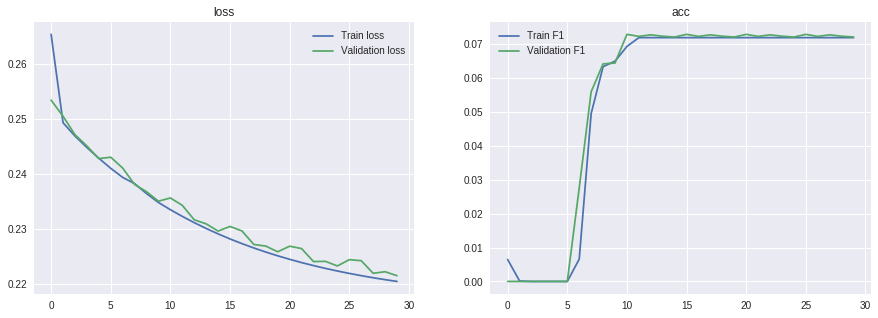

In [0]:
#ModelAll - Loss and F1 Acc

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [0]:
#ModelA - Loss and F1 Acc

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(historyA.epoch, historyA.history["loss"], label="Train loss")
ax[0].plot(historyA.epoch, historyA.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(historyA.epoch, historyA.history["f1"], label="Train F1")
ax[1].plot(historyA.epoch, historyA.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [0]:
#ModelB - Loss and F1 Acc

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(historyB.epoch, historyB.history["loss"], label="Train loss")
ax[0].plot(historyB.epoch, historyB.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(historyB.epoch, historyB.history["f1"], label="Train F1")
ax[1].plot(historyB.epoch, historyB.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [0]:
#ModelC - Loss and F1 Acc

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(historyC.epoch, historyC.history["loss"], label="Train loss")
ax[0].plot(historyC.epoch, historyC.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(historyC.epoch, historyC.history["f1"], label="Train F1")
ax[1].plot(historyC.epoch, historyC.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [0]:
bestModel = load_model('./base.model', custom_objects={'f1': f1}) #, 'f1_loss': f1_loss})

In [0]:
fullValGen = vg

In [0]:
lastFullValPred = np.empty((0, 28))
lastFullValLabels = np.empty((0, 28))
for i in tqdm(range(len(fullValGen))): 
    im, lbl = fullValGen[i]
    scores = bestModel.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

(626, 28) (626, 28)


In [0]:
from sklearn.metrics import f1_score as off1
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j,t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
  1%|          | 10/1000 [00:00<00:20, 47.71it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 1000/1000 [00:22<00:00, 46.20it/s]


In [0]:
print('Individual F1-scores for each class:')
print(np.max(f1s, axis=0))
print('Macro F1-score CV =', np.mean(np.max(f1s, axis=0)))

Individual F1-scores for each class:
[0.45622688 0.01898734 0.1030303  0.00636943 0.04068858 0.04984424
 0.23413258 0.07384615 0.02834646 0.01269841 0.00953895 0.01898734
 0.22159091 0.1257485  0.29891304 0.00636943 0.16691069 0.04984424
 0.25869263 0.03453689 0.02834646 0.19856115 0.25139665 0.04375
 0.08854962 0.31493943 0.11445783 0.        ]
Macro F1-score CV = 0.11626086175595139


Probability threshold maximizing CV F1-score for each class:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


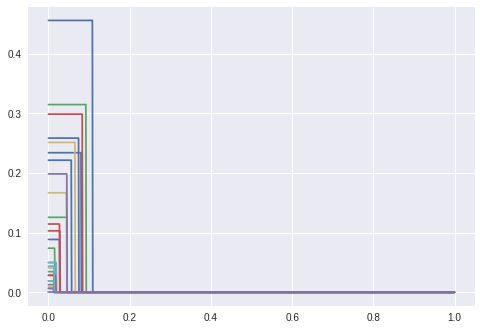

In [0]:
plt.plot(rng, f1s)
T = np.empty(28)
for i in range(28):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T)

In [0]:
# Get Test Data and predict classifications

pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, SHAPE)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

100%|██████████| 92/92 [01:51<00:00,  1.02it/s]


In [0]:
#Create csv for Kaggle submittion

PP = np.array(P)

prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('Test_Predictions.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 35890.54it/s]


In [0]:
#Check Labels for Predicted

submit

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
